In [1]:
import sys
sys.path.append("/home/sergio/TinyYOLOv3-Pedestrian-Detection")
from YOLOblocks import TinyYOLOv3,BasicBlock,PredictionLayer#,YOLOLossBasicBlock

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import time

import os
from skimage.io import imshow

import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


In [2]:
image_feature_description = {
    'bboxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'num_real_boxes':tf.io.FixedLenFeature([], tf.int64),
}

In [36]:
def get_iou_matrix_tf(box_arr1, box_arr2):
    
    box_arr1 = box_arr1 -tf.tile(box_arr1[:,:2],[1,2])
    #print(box_arr1)
    x11, y11, x12, y12 = tf.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(box_arr2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    yA = tf.maximum(y11, tf.transpose(y21))
    xB = tf.minimum(x12, tf.transpose(x22))
    yB = tf.minimum(y12, tf.transpose(y22))
    interArea = tf.maximum((xB - xA + 1e-9), 0) * tf.maximum((yB - yA + 1e-9), 0)
    boxAArea = (x12 - x11 + 1e-9) * (y12 - y11 + 1e-9)
    boxBArea = (x22 - x21 + 1e-9) * (y22 - y21 + 1e-9)
    iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)
    return iou,tf.argmax(iou,axis=1)#[:,tf.newaxis]


def fill_yolo_output(boxes,grid_size,num_anchors,which_anchor_box,which_anchor_box_index):
    #print(boxes.shape)
    #noobj_mask = tf.ones((1,grid_size*grid_size*num_anchors))
    #print(noobj_mask.shape)
    
    x_min,y_min,x_max,y_max =tf.split(boxes,4,axis=1)

    #Transforma las coordenadas de (xmin,ymin,xmax,ymax) --> (xcenter,ycenter,width,height)
    width = x_max-x_min
    height = y_max-y_min
    x_global =x_min + tf.math.divide(x_max - x_min,2)
    y_global =y_min + tf.math.divide(y_max - y_min,2)
    
    
    x_min_anchor,y_min_anchor,x_max_anchor,y_max_anchor =tf.split(which_anchor_box,4,axis=1)
    
    width_anchor = x_max_anchor-x_min_anchor
    height_anchor = y_max_anchor-y_min_anchor
    x_global_anchor =x_min_anchor + tf.math.divide(x_max_anchor - x_min_anchor,2)
    y_global_anchor =y_min_anchor + tf.math.divide(y_max_anchor - y_min_anchor,2)   

    
    #print("el x original",x_global)
    #print("el y original",y_global)
    #print("el w original",width)
    #print("el h original",height)
    
    #porción de la imagen que hay en cada celda
    pixel_per_grid = tf.math.divide(1.,grid_size)
    #print(pixel_per_grid)
    
    #Obtenemos la coordenada de la celda donde están los boundingboxes
    offset_grid_x = x_global//pixel_per_grid
    offset_grid_y = y_global//pixel_per_grid
    
    #Obtenemos el el centro locacon referencia  al celda encontrada previamente
    x_local =tf.math.floormod(x_global,pixel_per_grid)
    y_local =tf.math.floormod(y_global,pixel_per_grid)
    #print(x_local,y_local)
    
    #Valores tx e ty del groudtruth
    tx = tf.math.log(x_local + 1e-07/(1-x_local))
    ty = tf.math.log(y_local+1e-07/(1-y_local))
    tw = tf.math.log(tf.math.divide(width+1e-07,width_anchor))
    th = tf.math.log(tf.math.divide(height+1e-07,height_anchor))
    tobj_mask = tf.ones_like(tx)
    tobj = tf.concat([tobj_mask,tobj_mask,tobj_mask],axis=0)
    
    #tnoobj = tf.zeros_like(tx)    
    #tobj = tf.ones((grid_size*grid_size*num_anchors,1))
    #tnoobj = tf.zeros((grid_size*grid_size*num_anchors,1))
    #print("Lo que la red debe predecir",tx.numpy(),ty.numpy(),tw.numpy(),th.numpy())
    #x_global = (offset_grid_x * pixel_per_grid) + tf.math.sigmoid(tx)
    #y_global = (offset_grid_y * pixel_per_grid) + tf.math.sigmoid(ty)
    #w = width_anchor*tf.math.exp(tw)
    #h = height_anchor*tf.math.exp(th)
    #print("obtnemos el x_real",x_global)
    #print("obtenemos el y_real",y_global)
    #print("obtenemos el w real",w)
    #print("obtenemos el h real",h)
    
    #anchor_boxes_per_output = num_anchors//2

    #Residuo indica cual de los 3 anchor boxes de la coordenada es la que llevara el 1
    #Coord representa la coordenada del grid
    
    residuo = tf.math.floormod(which_anchor_box_index,num_anchors)[:,tf.newaxis]
    coord = tf.cast(num_anchors*(offset_grid_y*grid_size + offset_grid_x),dtype=tf.int64)
    
    coord_objectness = tf.cast(num_anchors*(offset_grid_y*grid_size + offset_grid_x),dtype=tf.int64)
    coord_objectness2 = coord_objectness+1
    coord_objectness3 = coord_objectness+2
    coord_objectess_global = tf.concat([coord_objectness,coord_objectness2,coord_objectness3],axis=0)
    
    output_position = residuo+coord
    print("tipo de aoutput_positivon",output_position)
    
    print(output_position)
    
    dense_shape = grid_size*grid_size*num_anchors
    print(dense_shape)
    tx_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tx[:,0], dense_shape=[dense_shape]))
    ty_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=ty[:,0], dense_shape=[dense_shape]))
    tw_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tw[:,0], dense_shape=[dense_shape]))
    th_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=th[:,0], dense_shape=[dense_shape]))
    obj_mask = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tobj_mask[:,0], dense_shape=[dense_shape]))
    objectness_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=coord_objectess_global, values=tobj[:,0], dense_shape=[dense_shape]))
    #noobj_mask = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tnoobj[:,0], dense_shape=[dense_shape]))
    #obj_mask =tx_vector=ty_vector=tw_vector=th_vector = tf.zeros((1,grid_size*grid_size*num_anchors))
    
    tx_vector_dense = tf.sparse.to_dense(tx_vector, default_value=0, validate_indices=False, name="Dense_tx")
    ty_vector_dense = tf.sparse.to_dense(ty_vector, default_value=0, validate_indices=False, name="Dense_ty")
    tw_vector_dense = tf.sparse.to_dense(tw_vector, default_value=0, validate_indices=False, name="Dense_tw")
    th_vector_dense = tf.sparse.to_dense(th_vector, default_value=0, validate_indices=False, name="Dense_th")
    obj_mask_dense =  tf.sparse.to_dense(obj_mask, default_value=0, validate_indices=False, name="Dense_obj")
    #noobj_mask_dense = 1-obj_mask_dense
    objectness_vector_dense =  tf.sparse.to_dense(objectness_vector, default_value=0, validate_indices=False)
    
    #noobj_mask_dense= tf.sparse.to_dense(noobj_mask, default_value=1, validate_indices=False, name="Dense_noobj")
    ##print(tx_vector.to_dense)
    #print(tf.sparse.to_dense(tx_vector, default_value=0, validate_indices=True, name=None)
    #tx_vector=tx_vector[[3,2],]
    #tx_vector[output_position[:,0]] = tx
    #print("coordenada de la salida:",output_position)
    
    #return ((tx_vector_dense,ty_vector_dense,obj_mask_dense),(tw_vector_dense,th_vector_dense,obj_mask_dense),(objectness),(objectness))
    
    return tx_vector_dense,ty_vector_dense,tw_vector_dense,th_vector_dense,obj_mask_dense,objectness_vector_dense

def build_targets(image,image_bboxes,num_real_boxes,anchor_boxes):
    
    images_bboxes_original = image_bboxes
    #Obtenemos los boduing boxes que son reales
    image_bboxes = image_bboxes[:num_real_boxes,:]
    #print("Bouding boxes de la imagen",image_bboxes)
    #Obteneos  la matriz de IoU , y el índice del anchor box que dió mejor resultado
    
    #Nprmalizamos con respecto al tamaño de la imagen y obtenemos la Iou con los anchor boxes
    image_bboxes = tf.math.divide(image_bboxes,416)
    iou_matrix,which_anchor_box_index = get_iou_matrix_tf(image_bboxes,anchor_boxes)
    
    print(which_anchor_box_index)

    anchor_boxes_per_output = len(anchor_boxes)//2
    #Indices de los bouding boxes que irian en cada salida, index_best_ yolo nos dice que bouding boxes de la imagen van a la salida YOLO1,
    #porque su mejor IoU fue con los len(anchor_boxes)//2 anchor boxes mas grandes
    index_best_yolo1 = tf.where(which_anchor_box_index>=anchor_boxes_per_output)[:,0]
    index_best_yolo2 = tf.where(which_anchor_box_index<anchor_boxes_per_output)[:,0]
    index_best_anchor_yolo1 = tf.gather(which_anchor_box_index,index_best_yolo1,axis=0)
    index_best_anchor_yolo2 = tf.gather(which_anchor_box_index,index_best_yolo2,axis=0)
    
    print(index_best_yolo1)
    print(index_best_anchor_yolo1)

    print(index_best_yolo2)
    print(index_best_anchor_yolo2)

    
    best_bboxes_yolo1 = tf.gather(image_bboxes,index_best_yolo1,axis =0)
    best_anchors_yolo1 = tf.gather(anchor_boxes,index_best_anchor_yolo1, axis =0) #LOs dos anchor boxes grandes corrsponden a YOLO1
    best_bboxes_yolo2 = tf.gather(image_bboxes,index_best_yolo2,axis =0)
    best_anchors_yolo2 = tf.gather(anchor_boxes,index_best_anchor_yolo2, axis =0) #Los dos anchor boxes pequeños corresponden a YOLO2
    
    
    if best_anchors_yolo1.shape[0] !=0:
        tx_vector_yolo1,ty_vector_yolo1,tw_vector_yolo1,th_vector_yolo1,obj_mask_yolo1,obj_vector_yolo1= fill_yolo_output(best_bboxes_yolo1,13,anchor_boxes_per_output,best_anchors_yolo1,index_best_anchor_yolo1)
    else:
        tx_vector_yolo1=ty_vector_yolo1=tw_vector_yolo1=th_vector_yolo1=obj_mask_yolo1= obj_vector_yolo1=tf.zeros((1,grid_size*grid_size*num_anchors))
        #noobj_mask_yolo1 = tf.ones((1,13*13*num_anchors))
    
    if best_anchors_yolo2.shape[0] != 0:
        tx_vector_yolo2,ty_vector_yolo2,tw_vector_yolo2,th_vector_yolo2,obj_mask_yolo2,obj_vector_yolo2 = fill_yolo_output(best_bboxes_yolo2,26,anchor_boxes_per_output,best_anchors_yolo2,index_best_anchor_yolo2)
    else:
        tx_vector_yolo2=ty_vector_yolo2=tw_vector_yolo2=th_vector_yolo2=obj_mask_yolo2 = obj_vector_yolo2=tf.zeros((1,grid_size*grid_size*num_anchors))
        #noobj_mask_yolo2 = tf.ones((1,26*26*num_anchors))
        
    tx_vector = tf.concat([tx_vector_yolo1,tx_vector_yolo2],axis=0)[:,tf.newaxis]
    ty_vector = tf.concat([ty_vector_yolo1,ty_vector_yolo2],axis=0)[:,tf.newaxis]
    tw_vector = tf.concat([tw_vector_yolo1,tw_vector_yolo2],axis=0)[:,tf.newaxis]
    th_vector = tf.concat([th_vector_yolo1,th_vector_yolo2],axis=0)[:,tf.newaxis]
    obj_mask = tf.concat([obj_mask_yolo1,obj_mask_yolo2],axis=0)[:,tf.newaxis]
    #noobj_mask = tf.concat([noobj_mask_yolo1,noobj_mask_yolo2],axis=0)[:,tf.newaxis]
    obj_vector = tf.concat([obj_vector_yolo1,obj_vector_yolo2],axis=0)[:,tf.newaxis]
    
    #output = tf.concat([tx_vector,ty_vector,tw_vector,th_vector,obj_mask,noobj_mask,obj_vector],axis=1)
    #images_bboxes_original
    #return image,output
    #Vamos a regresar obj mask que es 1 cuando hay objeto en grid y el anchor box especifico
    #return tf.cast(image,tf.float32)/255,(tf.concat([tx_vector,ty_vector,obj_mask],axis=1),tf.concat([tw_vector,th_vector,obj_mask],axis=1),(obj_mask),(obj_mask))
    return tf.cast(image,tf.float32)/255,(tf.concat([tx_vector,ty_vector,obj_mask],axis=1),tf.concat([tw_vector,th_vector,obj_mask],axis=1),(obj_vector),(obj_vector))


def imgaug_data_augmentation(image,bboxes,num_real_boxes):
    im_shape = image.shape
    bbs = BoundingBoxesOnImage.from_xyxy_array(bboxes*416, shape=(416,416))
    
    policy = np.random.randint(5)
    
    #policy = 2
    if policy == 0:
        
        p = np.random.random()
        if p<=0.6:
            aug = iaa.TranslateX(px=(-60, 60),cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
        p = np.random.random()
        if p<=0.8:
            aug = iaa.HistogramEqualization()
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
    elif policy==1:
        
        p=np.random.random()
        if p<=0.2:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
        
        p=np.random.random()
        if p<=0.8:
            square_size = np.random.randint(48)
            aug = iaa.Cutout(nb_iterations=1, size=square_size/416, squared=True)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
    elif policy==2:
        p=np.random.random()
        if p<=1:
            aug = iaa.ShearY(shear=(int(-0.06*416), int(0.06*416)), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
        p=np.random.random()
        if p<=0.6:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
            
    elif policy==3:
        p=np.random.random()
        if p<=0.6:    
            aug = iaa.Rotate(rotate=(-30, 30), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs_aug.remove_out_of_image().clip_out_of_image()
        
        p=np.random.random()
        if p<=1:
            aug = iaa.MultiplySaturation((0.54, 1.54))
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
    bbs.remove_out_of_image()
    
    return image,np.clip(bbs.to_xyxy_array(np.float32),1,415),num_real_boxes,policy
    
    
def preprocessing(example_proto):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_jpeg(image_features['image_raw'],channels = 3)
    image = tf.cast(tf.image.resize(image,size=(416,416)), tf.uint8)
    bboxes =  tf.io.parse_tensor(image_features['bboxes'], out_type=tf.float32)
    
    num_real_boxes = image_features['num_real_boxes']
    return image,bboxes,num_real_boxes

def preprocessing_validation_set(example_proto):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_jpeg(image_features['image_raw'],channels = 3)
    image = tf.cast(tf.image.resize(image,size=(416,416)), tf.uint8)
    bboxes =  tf.io.parse_tensor(image_features['bboxes'], out_type=tf.float32)
    bboxes = tf.clip_by_value(bboxes*416,1,415)
    
    num_real_boxes = image_features['num_real_boxes']
    return image,bboxes,tf.cast(num_real_boxes,tf.int64)
    
@tf.function(input_signature=[tf.TensorSpec((416,416,3), tf.uint8),tf.TensorSpec((None,4), tf.float32),tf.TensorSpec((), tf.int64)]) 
def tf_numpy_albumentations_real(image,bboxes,num_real_boxes):
    
    boxes_shape = bboxes.shape
    im_shape = image.shape

    image,bboxes,num_real_boxes = tf.numpy_function(imgaug_data_augmentation,[image,bboxes,num_real_boxes],Tout =[tf.uint8,tf.float32,tf.int64])
 
    image.set_shape(im_shape)
    bboxes.set_shape(boxes_shape)
    print("Imagen data type",image.dtype)
    print("Bboxes data type",bboxes.dtype)
    print("num_real_boxes",num_real_boxes.dtype)

    return image,bboxes,num_real_boxes

In [43]:
#USANDO TF.IMAGE MODULE
#anchors =tf.constant(np.array([[0,0,0.015,0.037],[0,0,0.043,0.104],[0,0,0.11,0.278],[0,0,0.351,0.66]]),dtype=tf.float32)
#anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)
anchors =tf.constant(np.array([[0,0,0.02078,0.049],[0,0,0.0426,0.128],[0,0,0.08523,0.19356],[0,0,0.1506,0.4163],[0,0,0.27835,0.58651],[0,0,0.5632,0.78614]]),dtype=tf.float32)

os.chdir("/home/sergio/Documents/pedestrian_dataset_train_tfr")
filenames = os. listdir()
raw_image_dataset = tf.data.TFRecordDataset(filenames)

os.chdir("/home/sergio/Documents/pedestrian_dataset_val_tfr_fixed")
filenames = os. listdir()
raw_image_dataset_val =tf.data.TFRecordDataset(filenames)

os.chdir("/home/sergio/Documents/pedestrian_dataset_train_tfr")
#.shuffle(70000)
train_dataset = raw_image_dataset.map(preprocessing,num_parallel_calls=8)
#train_dataset = train_dataset.map(tf_numpy_albumentations_real,num_parallel_calls=8)
#train_dataset = train_dataset.map(lambda x,y,z:build_targets(x,y,z,anchors),num_parallel_calls=8)
train_dataset = train_dataset.batch(16)

#os.chdir("/home/sergio/Documents/pedestrian_dataset_val_tfr_fixed")
val_dataset = raw_image_dataset_val.map(preprocessing_validation_set,num_parallel_calls=8)
#val_dataset = val_dataset.map(lambda x,y,z:build_targets(x,y,z,anchors),num_parallel_calls=8)
val_dataset = val_dataset.batch(16)

In [49]:
num_batch=2020
for index,i in enumerate(train_dataset):
    if index == num_batch:
        break
    

In [50]:
import os
print(os.getcwd())

/home/sergio/Documents/pedestrian_dataset_train_tfr


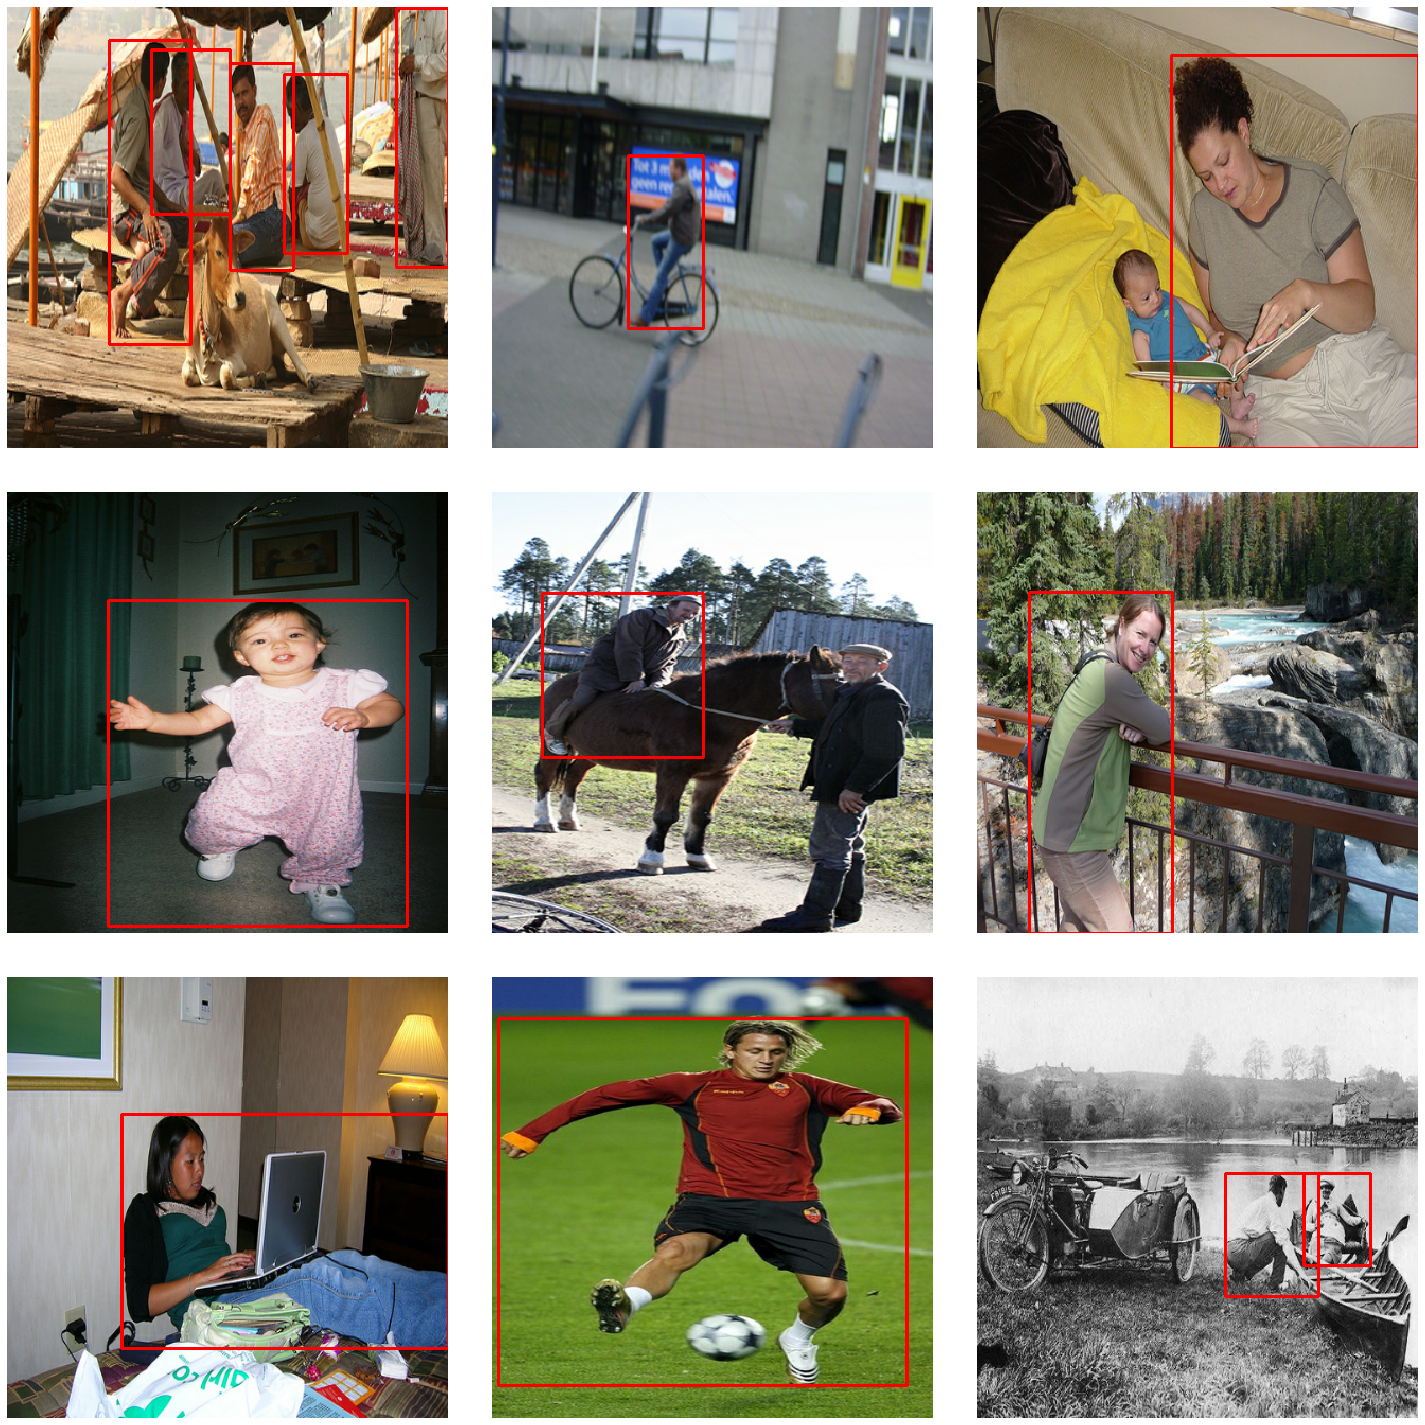

In [56]:
import matplotlib.pyplot as plt
import cv2
plt.rcParams['figure.figsize'] = [20, 20]
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    #x_center, y_center, width, height = bbox#*416
    x_min,y_min,x_max,y_max=bbox*416
    #x_min = int(x_center-(width//2))
    #y_min = int(y_center-(height//2))
    #x_max = int(x_center+(width//2))
    #y_max = int(y_center+(height//2))
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox)
    plt.imshow(img)


images,bboxes,num_boxes_real = i
num_images =9
grid_subplots = '33'


np.random.seed(6)

chosen_images = np.random.choice(16,num_images,replace=False)

#from matplotlib import gridspec
#gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1],
#         wspace=0.0, hspace=0.0, top=1, bottom=1, left=0, right=0) 

plt.subplots_adjust(bottom=0.01, right=0.99, top=0.99,left=0.01,hspace=0.1,wspace=0.1)
for num,index in enumerate(chosen_images):
    
    plt.subplot(grid_subplots+str(num))
    plt.axis('off')
    visualize(images[index,:].numpy(),bboxes[index,0:num_boxes_real[index]])

#plt.savefig("sample_dataset_with_da.png")
plt.show()

In [57]:
image_aug,bboxes_aug,num_boxes_aug,policy = imgaug_data_augmentation(images[9,:].numpy(),bboxes[9,:],num_boxes_real[9].numpy())#.reshape((1,1)))

In [58]:
num_boxes_aug

5

In [59]:
def visualize(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox)
    plt.imshow(img)

3
0
3
4
1
3
2
1
0


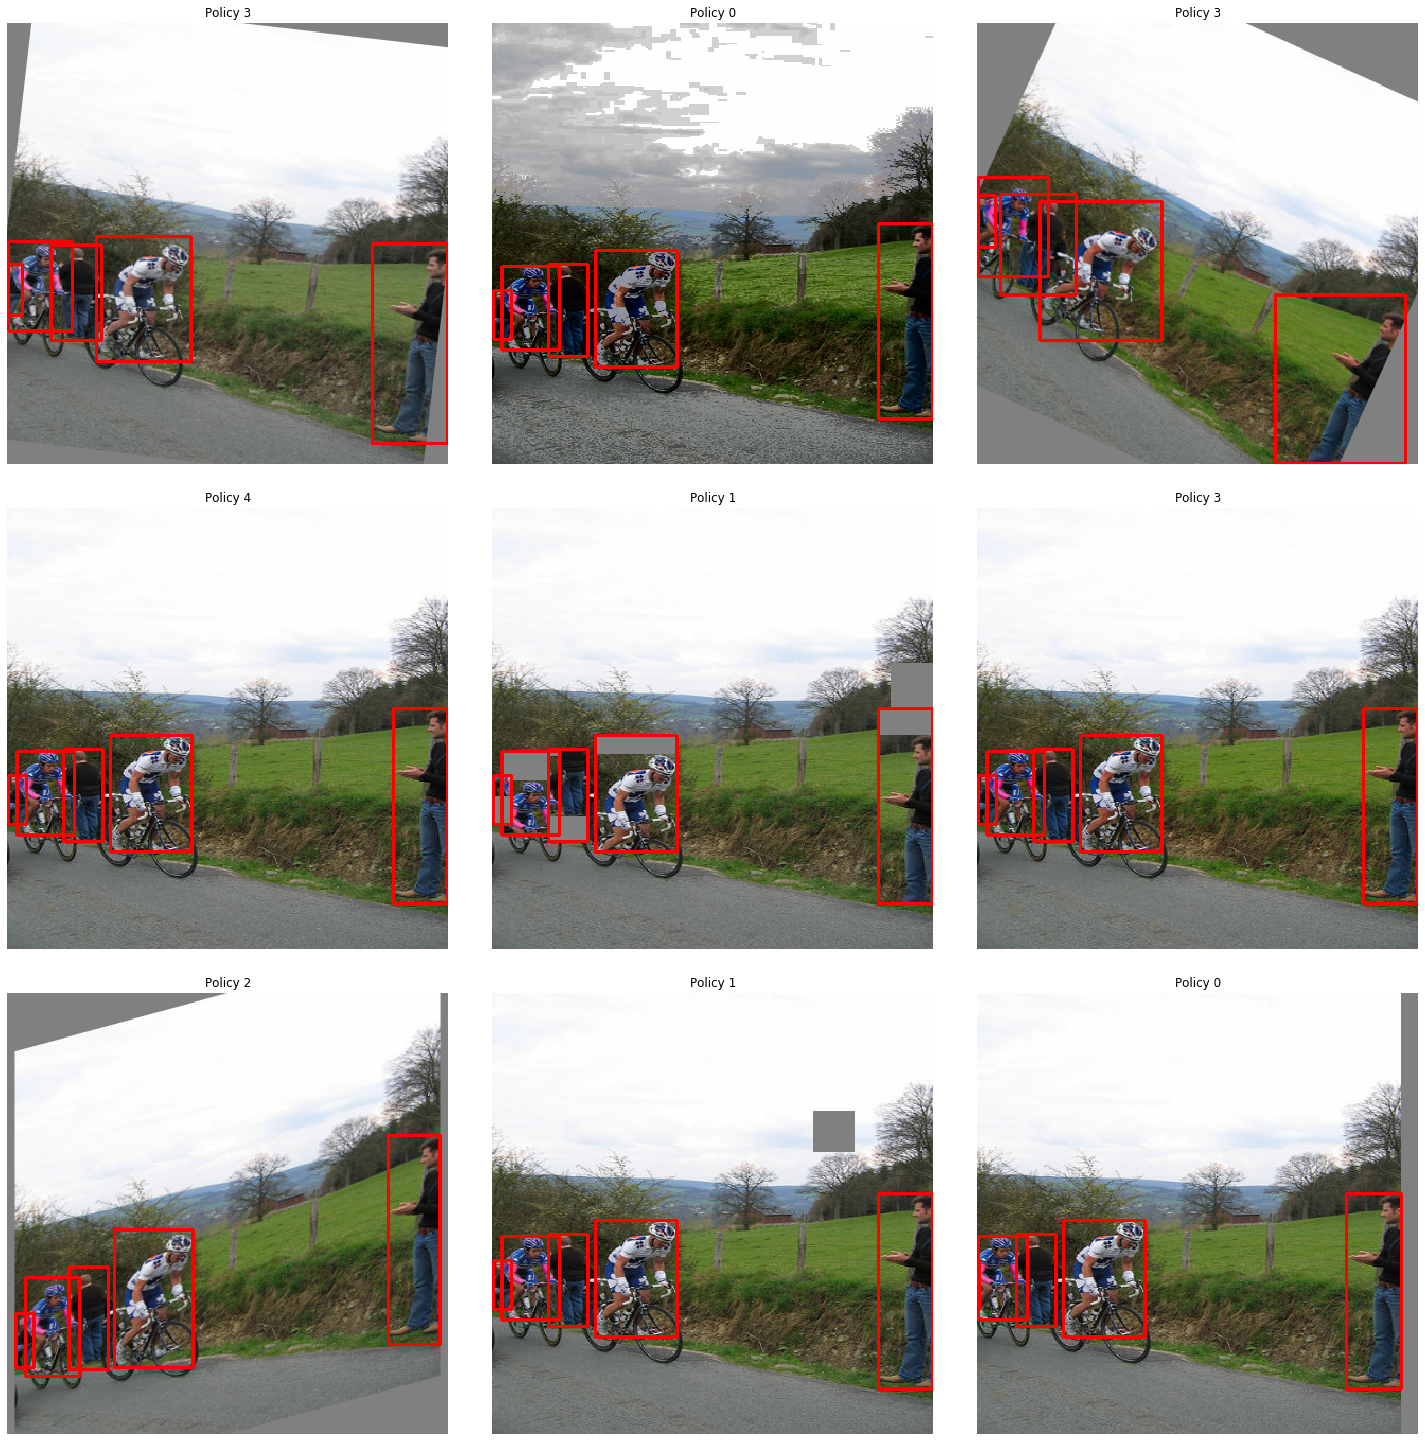

In [60]:
num_images =9
np.random.seed(5)
'''
0
4
4
0
0
1
3
0
2
'''
plt.subplots_adjust(bottom=0.01, right=0.99, top=0.99,left=0.01,hspace=0.1,wspace=0.1)
for experimento in range(1,num_images+1):
    
    plt.subplot(3,3,experimento)
    image_aug,bboxes_aug,num_boxes_aug,policy = imgaug_data_augmentation(images[9,:].numpy(),bboxes[9,:],num_boxes_real[9].numpy())
    plt.title("Policy "+str(policy))
    visualize(image_aug,bboxes_aug[:np.int32(num_boxes_aug),:]/416)
    print(policy)
    plt.axis('off')
    
plt.savefig("same_image_diff_policies_da")
plt.show()

In [178]:
chosen_images

array([12, 14,  6,  7,  2,  8,  5, 13,  1])

In [140]:
from urllib.request import urlopen

import numpy as np
import cv2
from matplotlib import pyplot as plt

In [104]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)

In [94]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [5]:
image = download_image('https://d177hi9zlsijyy.cloudfront.net/wp-content/uploads/sites/2/2018/05/11202041/180511105900-atlas-boston-dynamics-robot-running-super-tease.jpg')

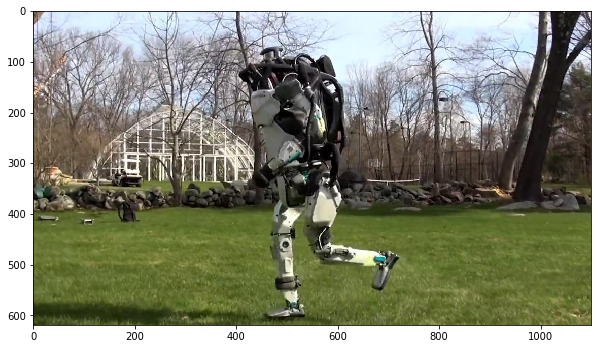

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [7]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

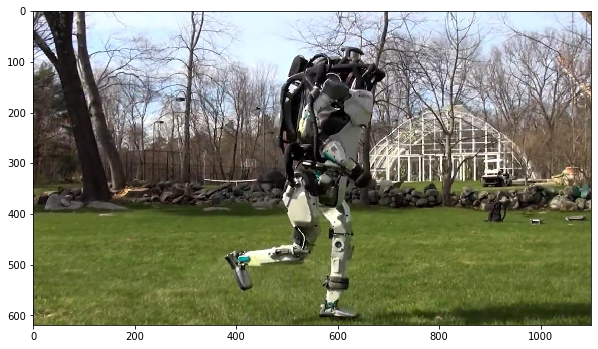

In [8]:
aug = HorizontalFlip(p=1)
augment_and_show(aug, image)

In [9]:
aug = IAAPerspective(scale=0.2, p=1)
augment_and_show(aug, image)

Exception: Expected number, tuple of two number, list of number or StochasticParameter for cval, got <class 'bool'>.

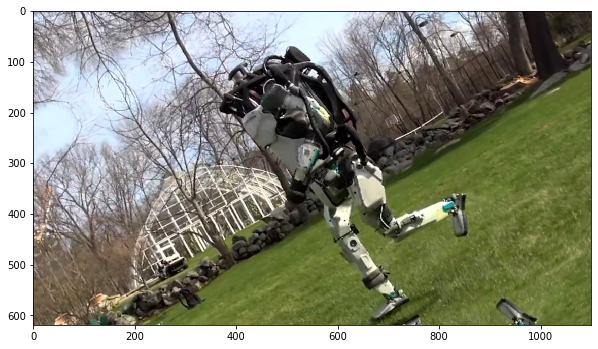

In [10]:
aug = ShiftScaleRotate(p=1)
augment_and_show(aug, image)

In [11]:
def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
        RandomRotate90(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
        HueSaturationValue()
    ], p=p)

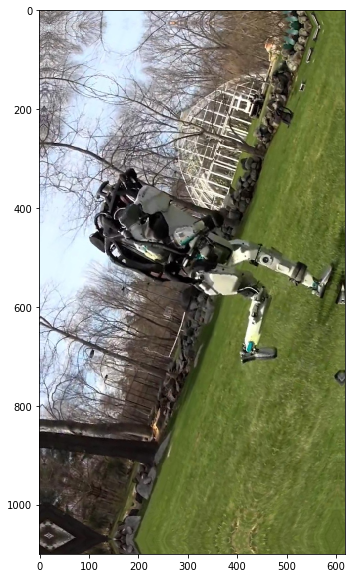

In [16]:
aug = augment_flips_color(p=1)
augment_and_show(aug, image)

In [17]:
def strong_aug(p=.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)


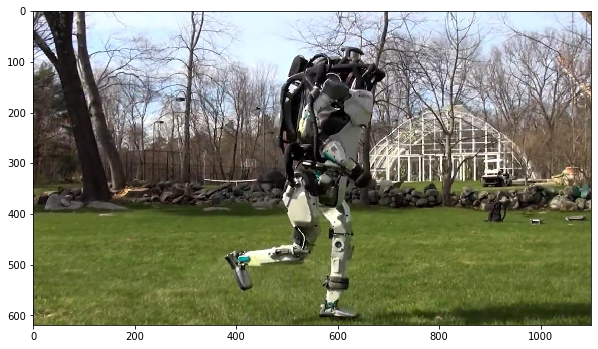

In [24]:
aug = strong_aug(p=1)
augment_and_show(aug, image)